In [29]:
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense, Input, Dropout
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt

In [31]:
def generate_seq(init_cond, length):
    seq = init_cond.copy()
    for _ in range(length - len(init_cond)):
        x = seq[-10:]
        next_val = (
            0.5 * math.sin(2*x[-1]) +
            0.2 * math.tanh(x[-3] * x[-2]) +
            0.6 * math.cos(x[-5] + x[-6]) -
            0.2 * (x[-7] ** 2) +
            0.05 * math.log(abs(x[-10]) + 1e-3)+
            0.005 * np.random.randn()
        )
        seq.append(next_val)
    return seq

def create_dataset(num_sequences=1000):
    sequences = []
    for _ in range(num_sequences):
        init_cond = np.random.uniform(-1, 1, 10).tolist()
        length = np.random.randint(50, 100)
        sequences.append(generate_seq(init_cond, length))
    return sequences

def prepare_data(sequences, min_len=10, max_len=30):
    X, y = [], []
    for seq in sequences:
        seq_len = np.random.randint(min_len, min(max_len, len(seq)-1))
        for i in range(len(seq) - seq_len):
            X.append(seq[i:i+seq_len])
            y.append(seq[i+seq_len])
    return np.array(X, dtype=object), np.array(y)

sequences = create_dataset()
X, y = prepare_data(sequences)

max_len = max(len(x) for x in X)
X_padded = tf.keras.preprocessing.sequence.pad_sequences(
    X, maxlen=max_len, padding='post', dtype='float32'
)[..., np.newaxis]

In [69]:
# inp = Input(shape=(None, 1))
# x = LSTM(64)(inp)
# out = Dense(1)(x)
# model1 = Model(inp, out)
# model1.compile(optimizer='adam', loss='mse')
# model1.fit(X_padded, y, epochs=20, batch_size=32)
# model1.save('models/model1.keras')
model1 = tf.keras.models.load_model('models/model1.keras')
# def build_model():
#     inp = Input(shape=(None, 1))
#     x = LSTM(64, return_sequences=True)(inp)
#     x = LSTM(32)(x)
#     out = Dense(1)(x)
#     return Model(inp, out)
# model2 = build_model()
# model2.compile(optimizer='adam', loss='mse')
# model2.fit(X_padded, y, epochs=20, batch_size=32)
# model2.save('models/model2.keras')
model2 = tf.keras.models.load_model('models/model2.keras')
# inp = Input(shape=(None, 1))
# x = LSTM(64, return_sequences=True)(inp)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32)(x)
# out = Dense(1)(x)
# model3 = Model(inp, out)
# model3.compile(optimizer='adam', loss='mse')
# model3.fit(X_padded, y, epochs=20, batch_size=32)
# model3.save('models/model3.keras')
model3 = tf.keras.models.load_model('models/model3.keras')
# inp = Input(shape=(None, 1))
# x = LSTM(64, return_sequences=True)(inp)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32, return_sequences=True)(x)
# x = LSTM(32)(x)
# out = Dense(1)(x)
# model4 = Model(inp, out)
# model4.compile(optimizer='adam', loss='mse')
# model4.fit(X_padded, y, epochs=20, batch_size=32)
# model4.save('models/model4.keras')
model4 = tf.keras.models.load_model('models/model4.keras')

In [54]:
test_init = np.random.uniform(-1, 1, 20).tolist()

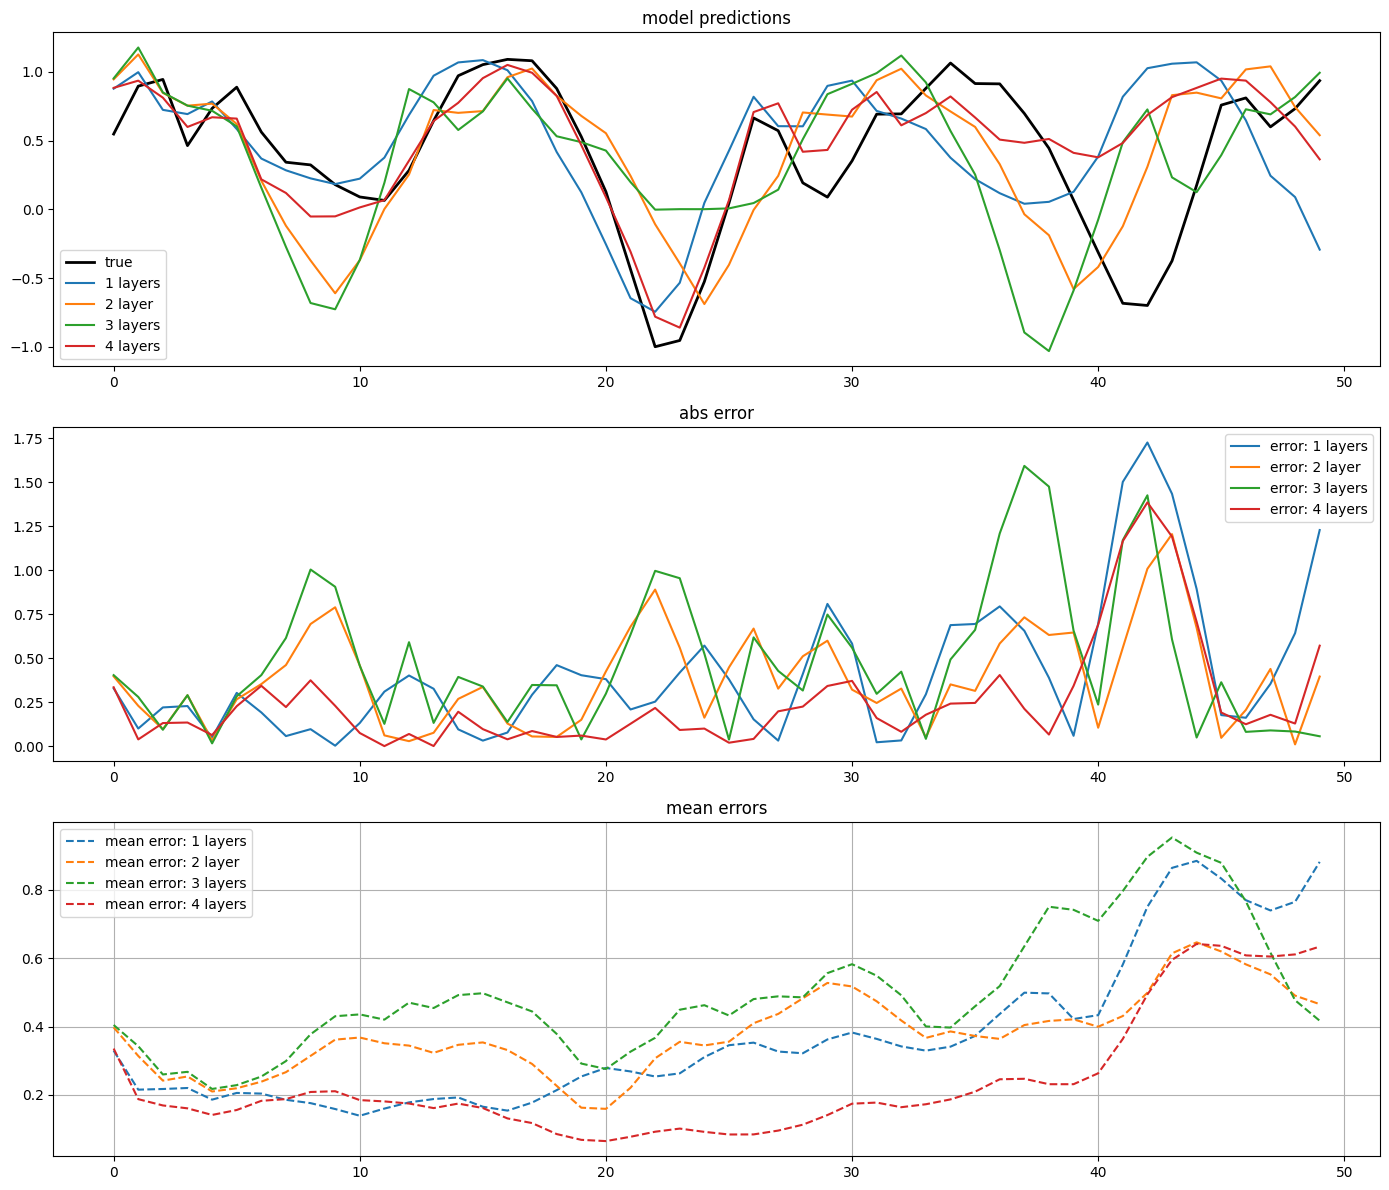

mean error for 1:  0.8817030962294676
mean error for 2:  0.46563596134046453
mean error for 3:  0.4170908058014219
mean error for 4:  0.6339236827370862


In [70]:
def draw_multiple_models(models, model_names, test_init, steps=50):
    true_sequence = generate_seq(test_init, steps+len(test_init))

    all_predictions = []
    all_errors = []

    for model in models:
        test_seq = test_init.copy()
        predictions = []
        errors = []
        mean_errors = []

        for i in range(steps):
            input_len = min(15, len(test_seq))
            x = np.array(test_seq[-input_len:])[np.newaxis, ..., np.newaxis]

            pred = model.predict(x, verbose=0)[0, 0]
            test_seq.append(pred)
            predictions.append(pred)

            true_val = true_sequence[len(test_init) + i]
            error = abs(pred - true_val)
            errors.append(error)
        
            size=min(10, len(errors))
            mean_errors.append(np.mean(errors[-size:]))

        all_predictions.append(predictions)
        all_errors.append((errors, mean_errors))

    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    plt.plot(true_sequence[len(test_init):], label='true', color='black', linewidth=2)

    for i, preds in enumerate(all_predictions):
        plt.plot(range(steps), preds, label=model_names[i])

    plt.title('model predictions')
    plt.legend()

    plt.subplot(3, 1, 2)
    for i, (errors, _) in enumerate(all_errors):
        plt.plot(errors, label=f'error: {model_names[i]}')

    plt.title('abs error')
    plt.legend()

    plt.subplot(3, 1, 3)
    for i, (_, means) in enumerate(all_errors):
        plt.plot(means, label=f'mean error: {model_names[i]}', linestyle='--')

    plt.title('mean errors')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
    return all_errors

models = [model1, model2, model3, model4]
names = ['1 layers', '2 layer', '3 layers', '4 layers']

allerrors = draw_multiple_models(models, names, test_init)
print(f"mean error for 1:  {allerrors[0][1][-1]}")
print(f"mean error for 2:  {allerrors[1][1][-1]}")
print(f"mean error for 3:  {allerrors[2][1][-1]}")
print(f"mean error for 4:  {allerrors[3][1][-1]}")


In [ ]:
# 1 layer
def build_stateful_model1(weights, batch_size=1):
    inp = Input(batch_shape=(batch_size, None, 1))
    x = LSTM(64, stateful=True)(inp)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    model.set_weights(weights)
    return model

stateful_model1 = build_stateful_model1(model1.get_weights())

# 2 layer
def build_stateful_model2(weights, batch_size=1):
    inp = Input(batch_shape=(batch_size, None, 1))
    x = LSTM(64, return_sequences=True, stateful=True)(inp)
    x = LSTM(32, stateful=True)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    model.set_weights(weights)
    return model

stateful_model2 = build_stateful_model2(model2.get_weights())

# 3 layer
def build_stateful_model3(weights, batch_size=1):
    inp = Input(batch_shape=(batch_size, None, 1))
    x = LSTM(64, return_sequences=True, stateful=True)(inp)
    x = LSTM(32, return_sequences=True, stateful=True)(x)
    x = LSTM(32, stateful=True)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    model.set_weights(weights)
    return model

stateful_model3 = build_stateful_model3(model3.get_weights())

# 4 layer
def build_stateful_model4(weights, batch_size=1):
    inp = Input(batch_shape=(batch_size, None, 1))
    x = LSTM(64, return_sequences=True, stateful=True)(inp)
    x = LSTM(32, return_sequences=True, stateful=True)(x)
    x = LSTM(32, return_sequences=True, stateful=True)(x)
    x = LSTM(32, stateful=True)(x)
    out = Dense(1)(x)
    model = Model(inp, out)
    model.compile(optimizer='adam', loss='mse')
    model.set_weights(weights)
    return model

stateful_model4 = build_stateful_model4(model4.get_weights())

In [74]:
def reset_states(model):
    for layer in model.layers:
        if hasattr(layer, 'states'):
            layer.states[0].assign(tf.zeros_like(layer.states[0]))
            if len(layer.states) > 1:
                layer.states[1].assign(tf.zeros_like(layer.states[1]))

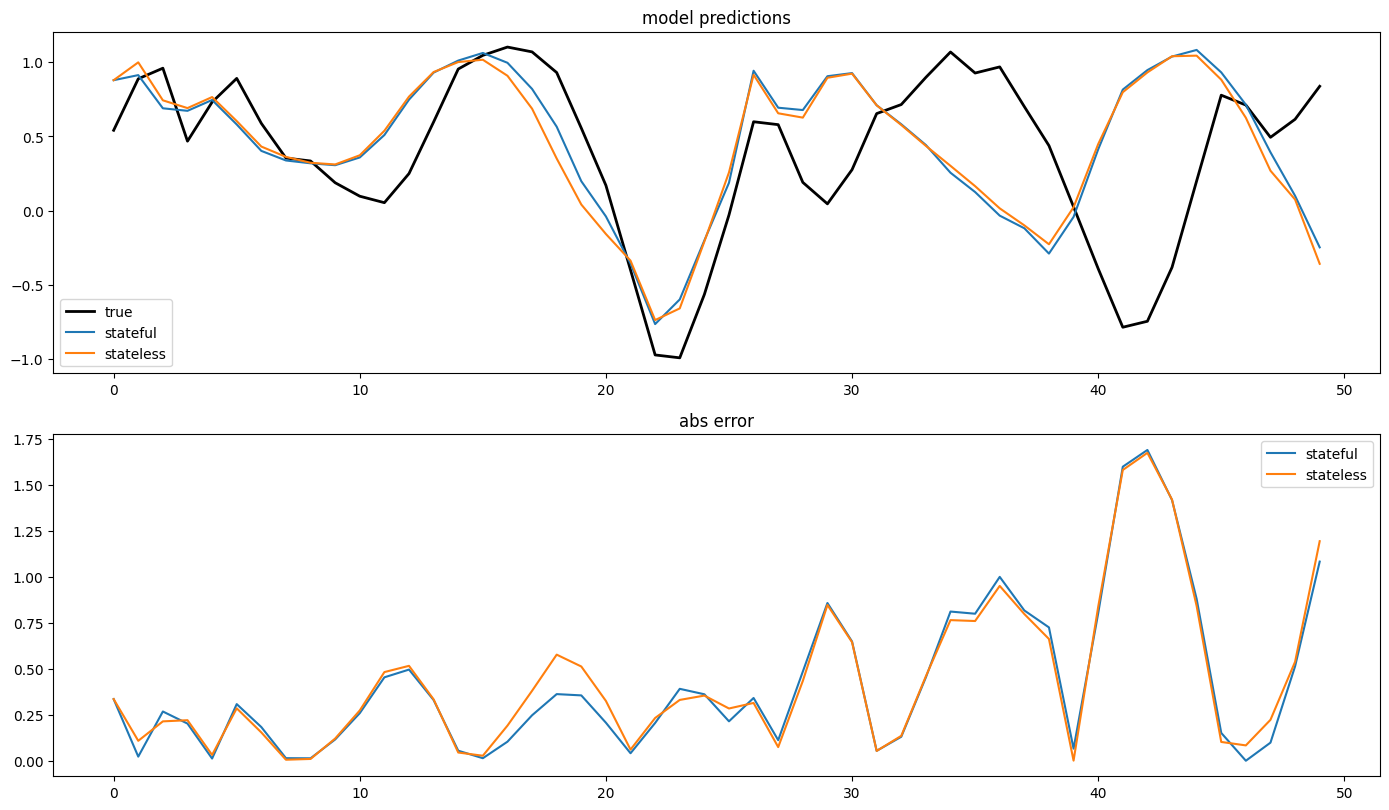

mean error for stateful:  0.42410538319151514
mean error for stateless:  0.43808673010171645


In [88]:
def draw_stateless_vs_stateful(stateless_model, stateful_model, test_init, steps=50):
    true_sequence = generate_seq(test_init, steps+len(test_init))

    test_seq_stateful = test_init.copy()
    test_seq_stateless = test_init.copy()
    predictions_stateful = []
    predictions_stateless = []
    errors_stateful = []
    errors_stateless = []

    for i in range(steps):
        input_len = min(15, len(test_seq_stateful))
        x = np.array(test_seq_stateful[-input_len:])[np.newaxis, ..., np.newaxis]

        pred = stateful_model.predict(x, verbose=0)[0, 0]
        test_seq_stateful.append(pred)
        predictions_stateful.append(pred)
        true_val = true_sequence[len(test_init) + i]
        error = abs(pred - true_val)
        errors_stateful.append(error)

        pred = stateless_model.predict(x, verbose=0)[0, 0]
        test_seq_stateless.append(pred)
        predictions_stateless.append(pred)
        true_val = true_sequence[len(test_init) + i]
        error = abs(pred - true_val)
        errors_stateless.append(error)
    
    plt.figure(figsize=(14, 12))

    plt.subplot(3, 1, 1)
    plt.plot(true_sequence[len(test_init):], label='true', color='black', linewidth=2)

    plt.plot(range(steps), predictions_stateful, label='stateful')
    plt.plot(range(steps), predictions_stateless, label='stateless')

    plt.title('model predictions')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(errors_stateful, label='stateful')
    plt.plot(errors_stateless, label='stateless')

    plt.title('abs error')
    plt.legend()

    plt.tight_layout()
    plt.show()
    return errors_stateful, errors_stateless

reset_states(stateful_model1)
errors_stateful, errors_stateless = draw_stateless_vs_stateful(model1, stateful_model1, test_init)
print(f"mean error for stateful:  {np.mean(errors_stateful)}")
print(f"mean error for stateless:  {np.mean(errors_stateless)}")

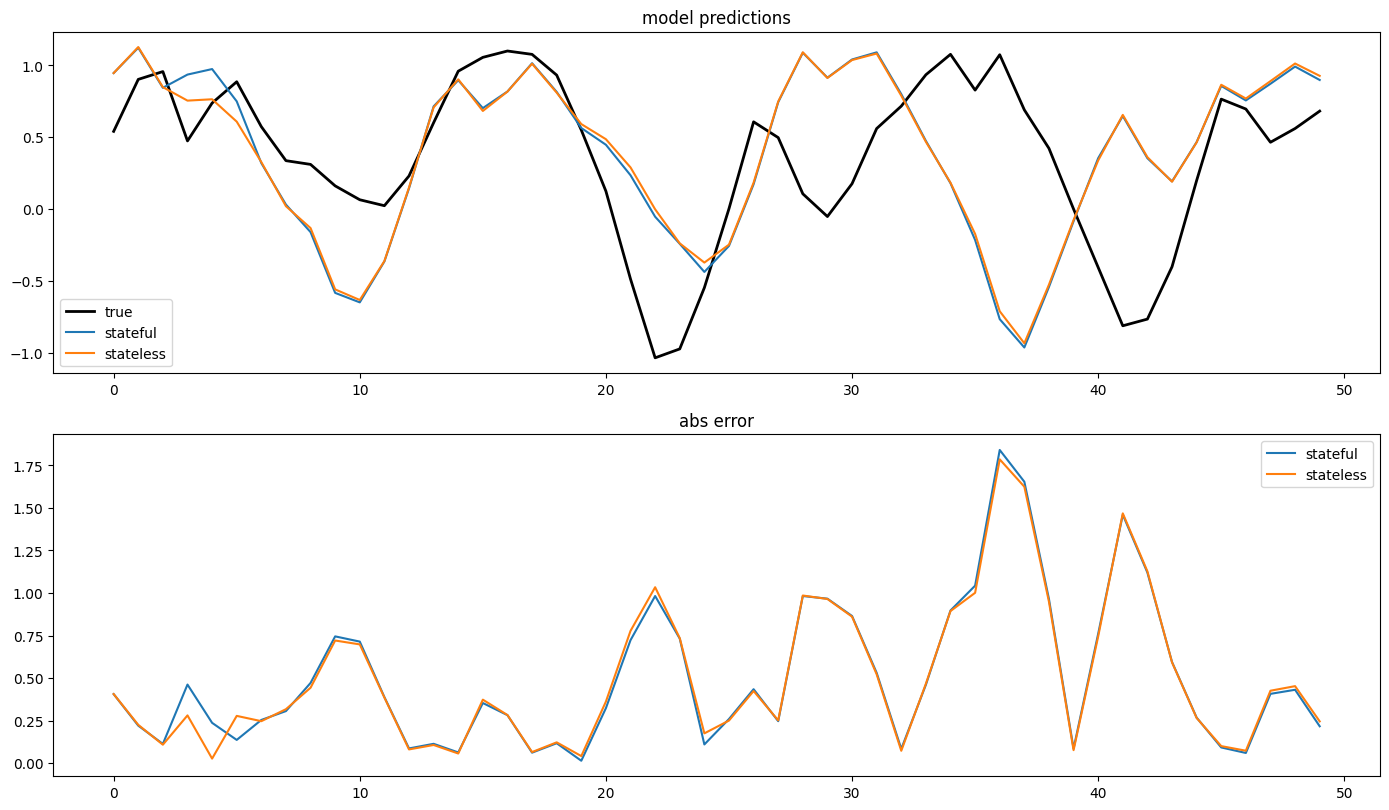

mean error for stateful:  0.5027269829489659
mean error for stateless:  0.4993558210559558


In [ ]:
print("2 lstm layers")
reset_states(stateful_model2)
errors_stateful, errors_stateless = draw_stateless_vs_stateful(model2, stateful_model2, test_init)
print(f"mean error for stateful:  {np.mean(errors_stateful)}")
print(f"mean error for stateless:  {np.mean(errors_stateless)}")

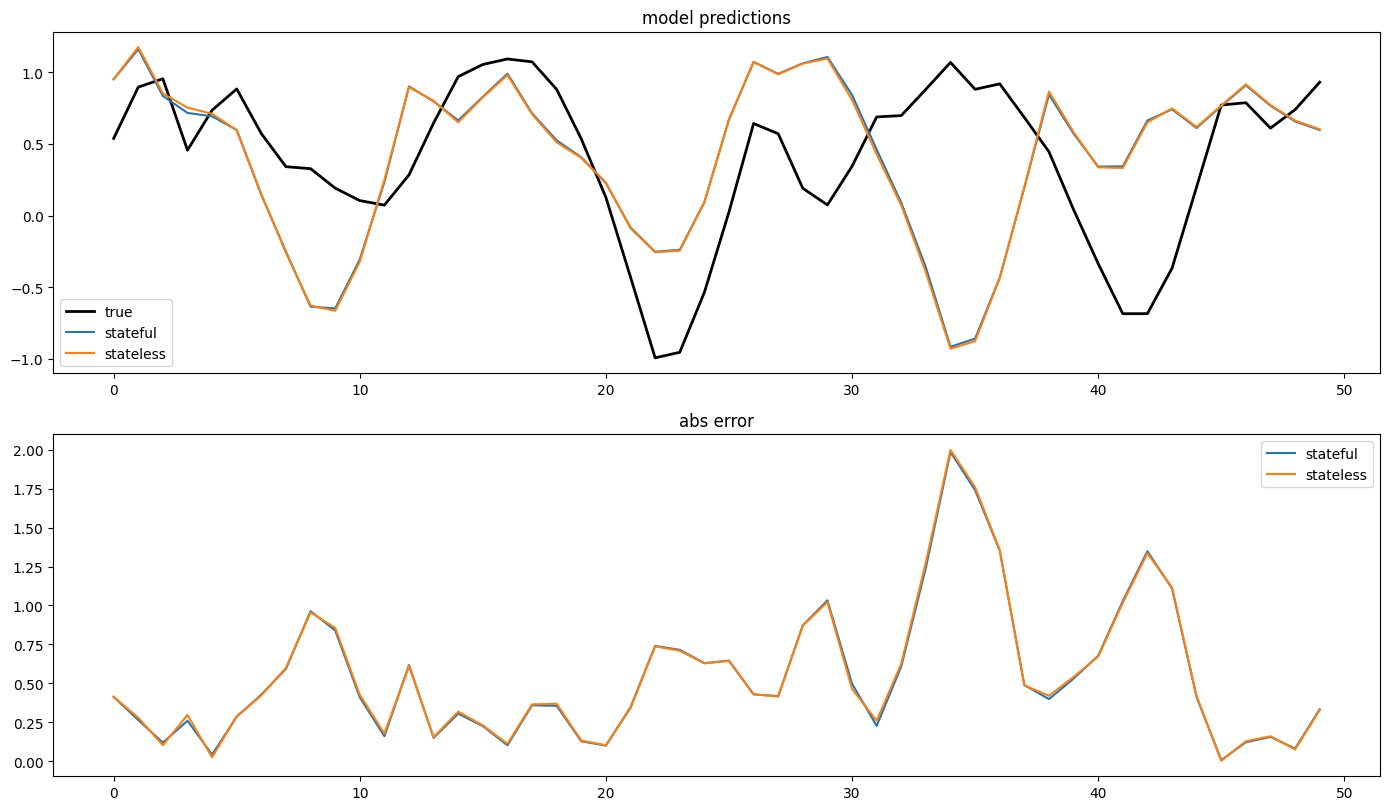

mean error for stateful:  0.5461736739887836
mean error for stateless:  0.5497079148604515


In [ ]:
print("3 lstm layers")
reset_states(stateful_model3)
errors_stateful, errors_stateless = draw_stateless_vs_stateful(model3, stateful_model3, test_init)
print(f"mean error for stateful:  {np.mean(errors_stateful)}")
print(f"mean error for stateless:  {np.mean(errors_stateless)}")

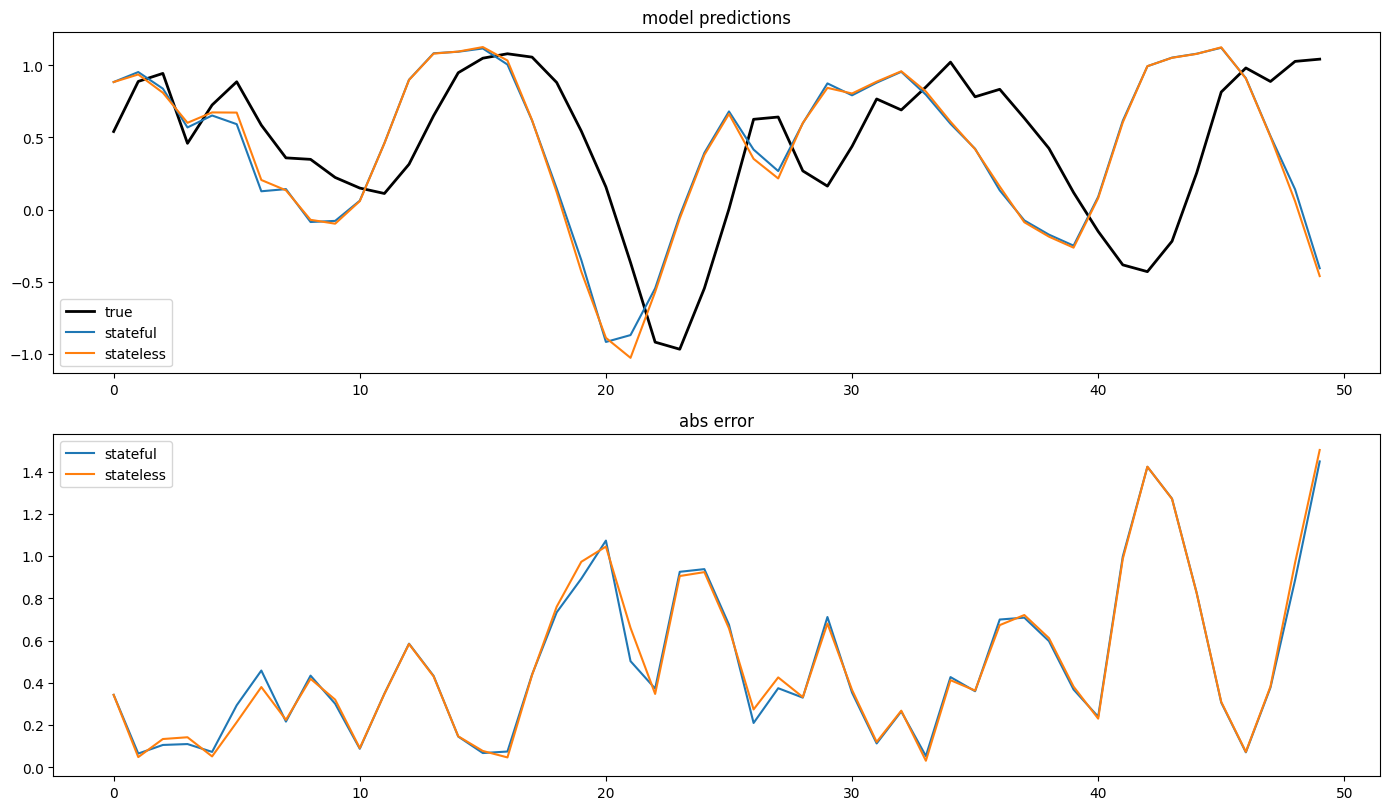

mean error for stateful:  0.48224143634692596
mean error for stateless:  0.4868066454972403


In [ ]:
print("4 lstm layers")
reset_states(stateful_model4)
errors_stateful, errors_stateless = draw_stateless_vs_stateful(model4, stateful_model4, test_init)
print(f"mean error for stateful:  {np.mean(errors_stateful)}")
print(f"mean error for stateless:  {np.mean(errors_stateless)}")